In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,make_scorer
from sklearn.model_selection import KFold,cross_validate


# Read data

In [2]:
col_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv("magic04.data")
df.columns = col_names
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.788,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.737,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.462,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.098,g


In [3]:
print(set(df['class']))

{'g', 'h'}


In [4]:
df.dropna(inplace=True)

<BarContainer object of 2 artists>

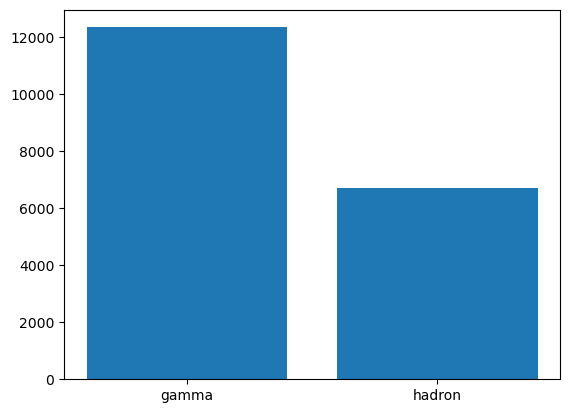

In [5]:
plt.bar(['gamma','hadron'],height=[len(df[df['class']=='g']),len(df[df['class']=='h'])])

# Balancing Data

In [6]:
df = df.groupby('class').sample(len(df[df['class']=='h']))

<BarContainer object of 2 artists>

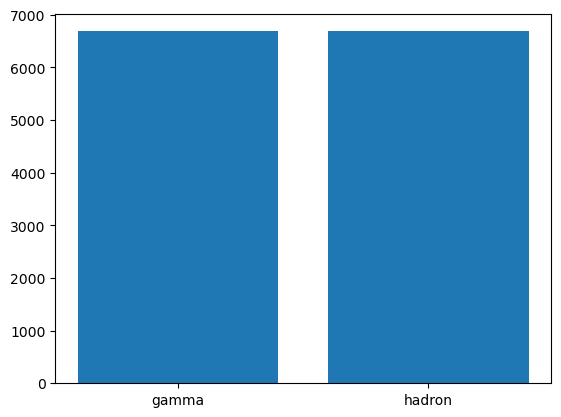

In [7]:
plt.bar(['gamma','hadron'],height=[len(df[df['class']=='g']),len(df[df['class']=='h'])])

# Visualizing Data Columns

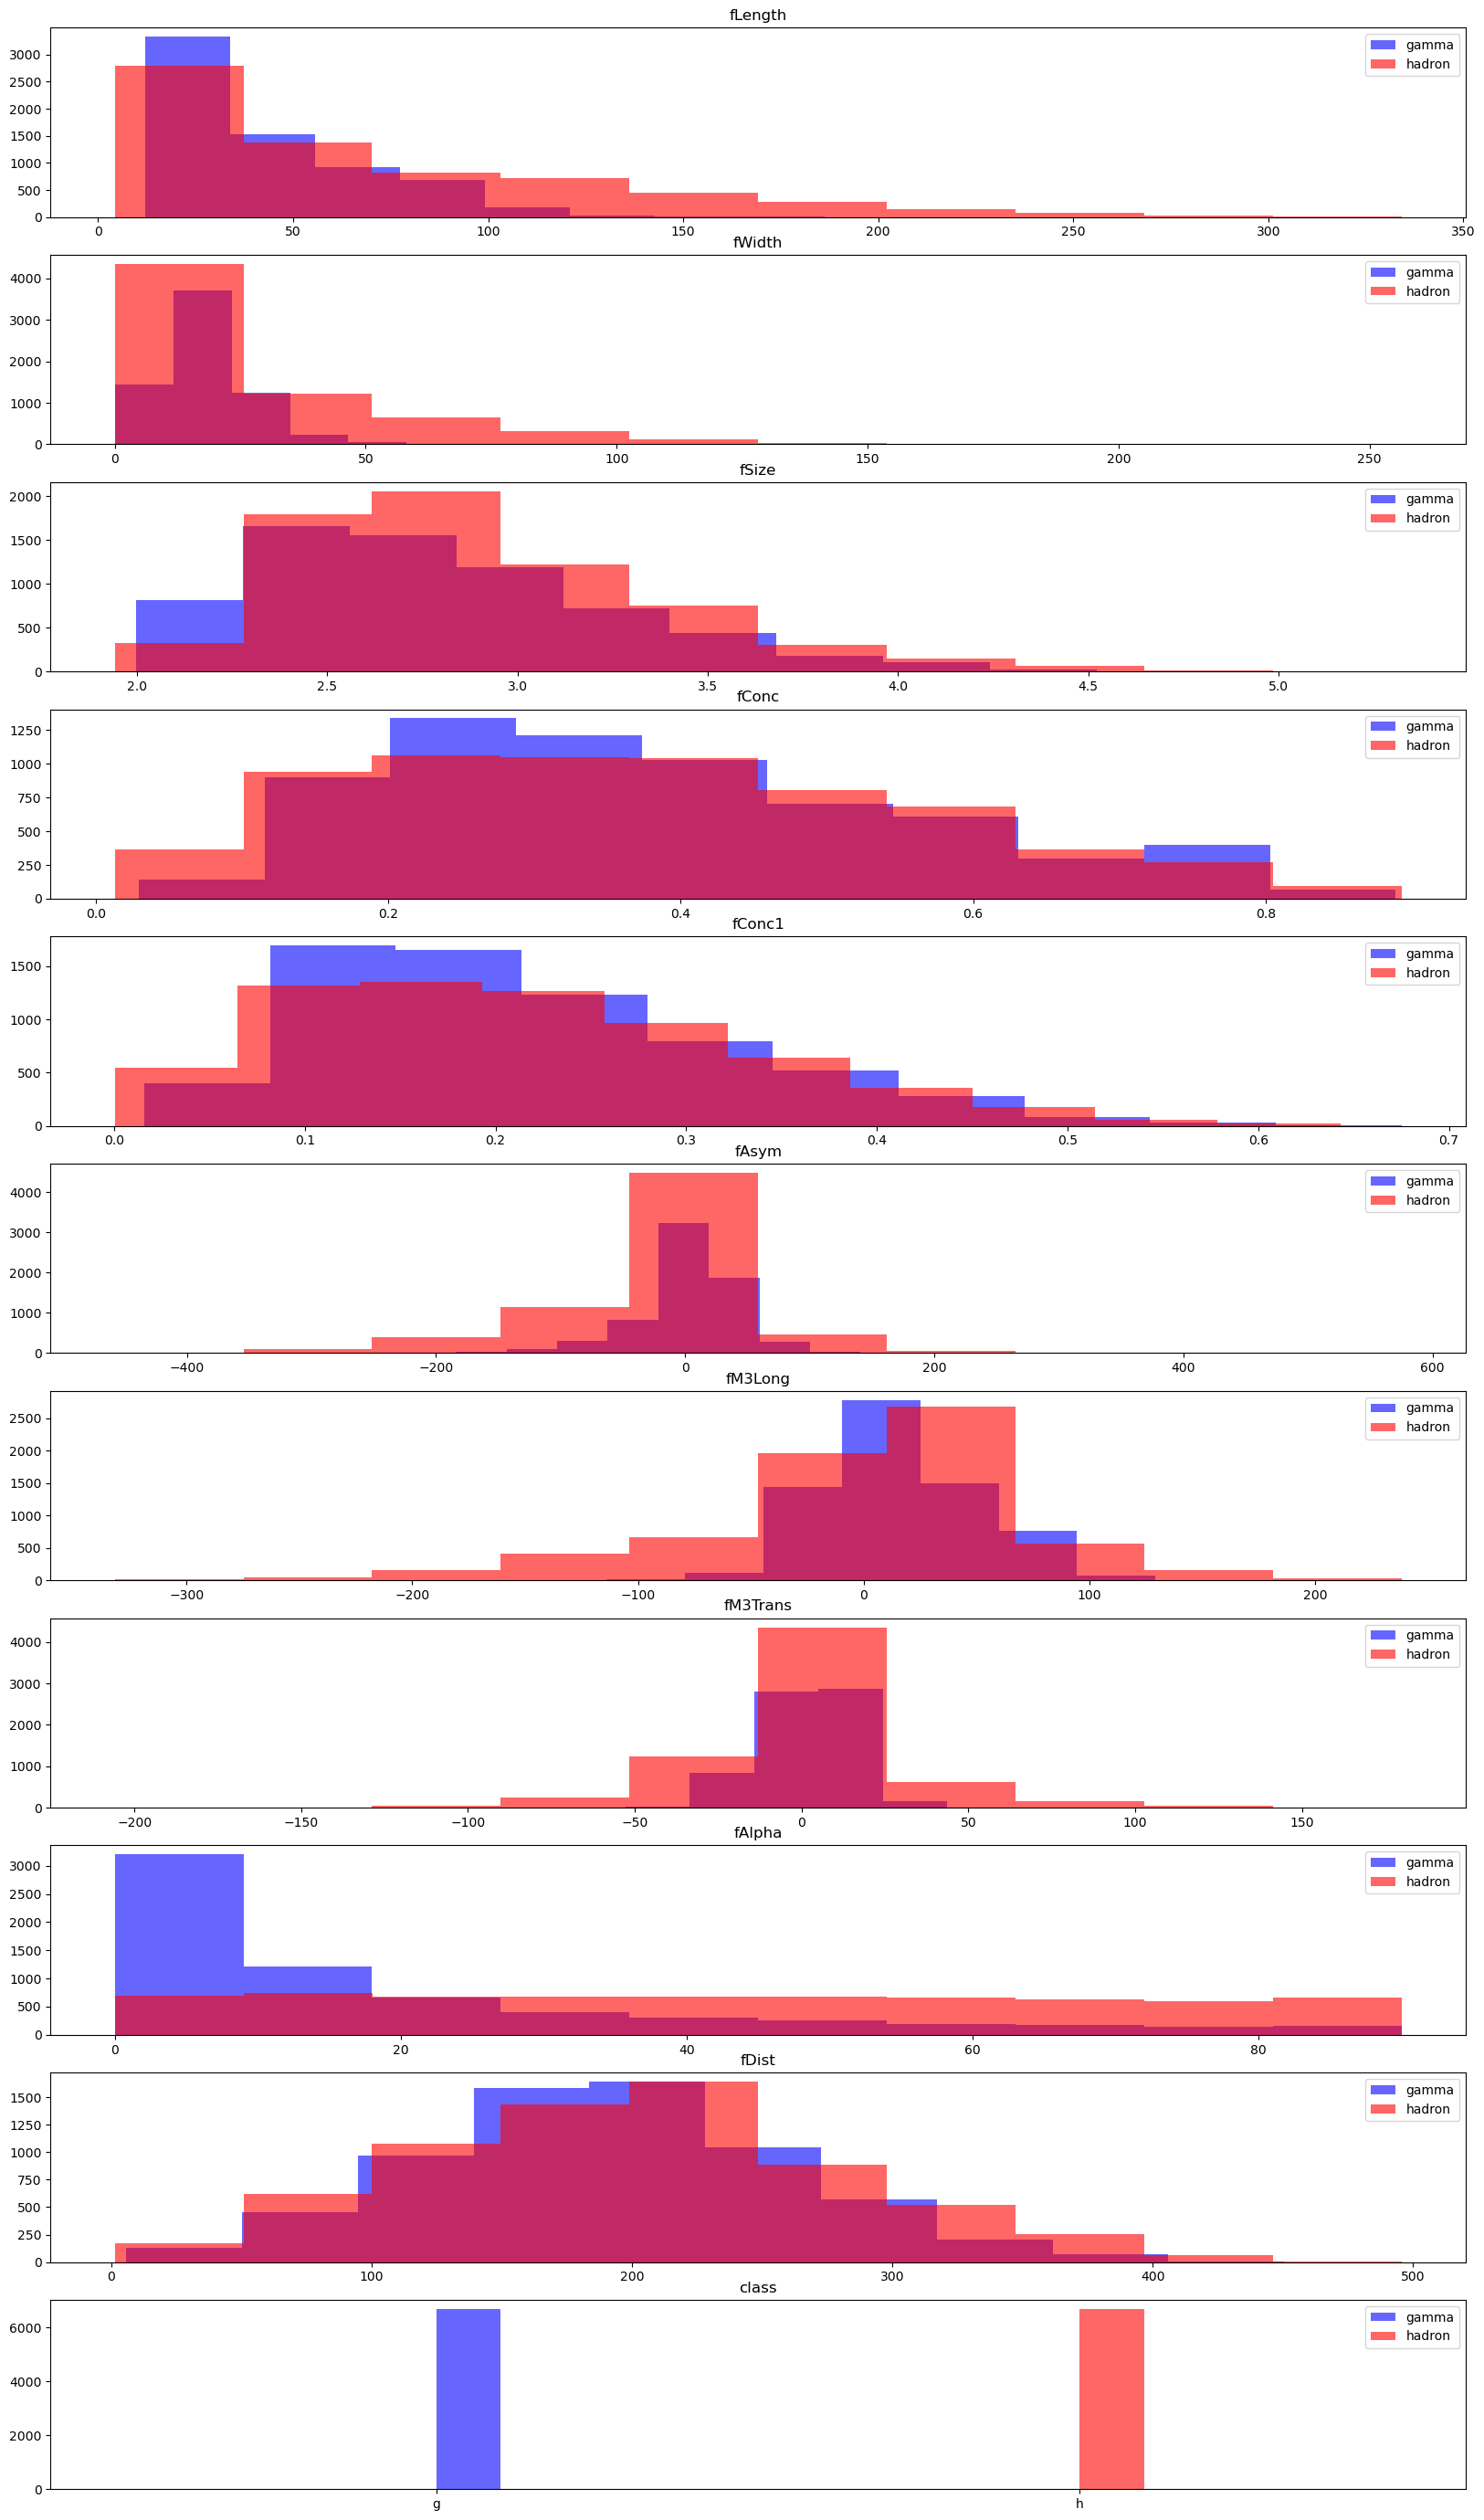

In [8]:
fig,axs = plt.subplots(11,figsize=(20,35))
for i,label in enumerate(df):
    axs[i].hist(df[df['class']=='g'][label],color='blue',alpha=0.6,label="gamma")
    axs[i].hist(df[df['class']=='h'][label],color='red',alpha=0.6,label="hadron")
    axs[i].title.set_text(label)
    axs[i].legend()
plt.show()

# Encoding

In [9]:
en = LabelEncoder()
df['class'] = en.fit_transform(df['class'])

In [10]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
4710,41.7854,17.7204,2.6365,0.3210,0.1721,-17.1632,-37.2658,13.6465,0.5310,197.7530,0
10250,41.8464,19.4302,3.1166,0.2217,0.1235,11.5249,27.9829,-11.9406,0.0920,193.5790,0
3165,95.2562,27.9901,3.1992,0.2851,0.1489,-66.8185,-71.2218,-24.3355,3.6810,376.2230,0
2855,13.0339,11.1611,2.0810,0.7552,0.3942,14.9112,-4.3689,11.7397,86.3258,84.3041,0
4526,48.2713,11.7368,2.5192,0.5446,0.2950,12.0288,40.4022,1.4286,10.3490,218.4330,0


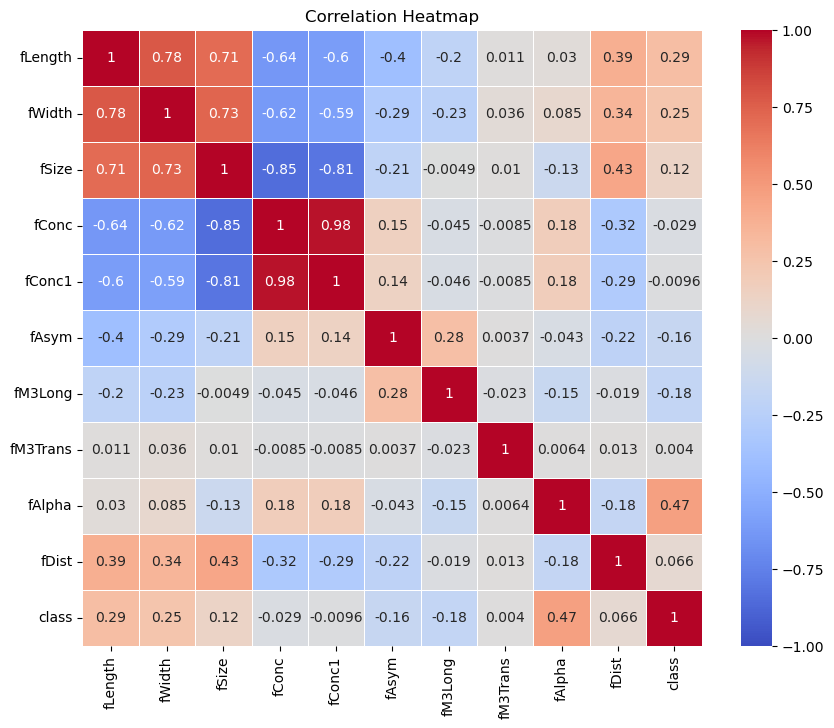

In [11]:
import seaborn as sns
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

plt.title("Correlation Heatmap")

plt.show()

# splitting

In [12]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [13]:
norm = StandardScaler()
X = norm.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,shuffle=True,train_size=0.7,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,random_state=42,shuffle=True,train_size=0.5,test_size=0.5)


<BarContainer object of 3 artists>

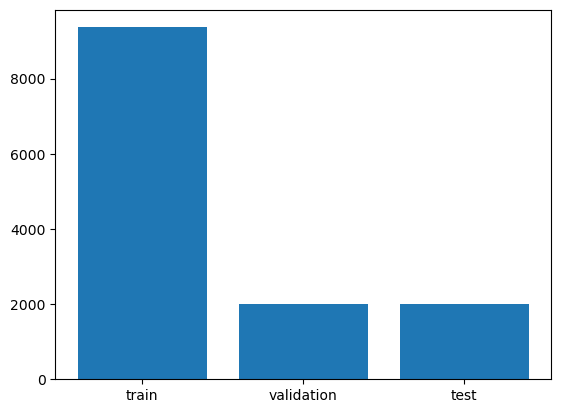

In [15]:
plt.bar(['train','validation','test'],[len(y_train),len(y_val),len(y_test)])

In [16]:
neighbors = range(1,100,2)

In [17]:
def compare(neighbors, X_train, X_val, y_train, y_val):
    accs = []
    prec = []
    rec = []
    f1_scores = []
    CMs = []
    
    for i in neighbors:
        model = KNeighborsClassifier(n_neighbors=i)

        # Train the model on the full training data
        model.fit(X_train, y_train)

        # Predict on training and validation sets
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate metrics for training set
        train_acc = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        
        # Calculate metrics for validation set
        val_acc = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        
        # Confusion matrix for validation
        cm = confusion_matrix(y_val, y_val_pred)

        # Append training and validation metrics
        accs.append((val_acc,train_acc))
        prec.append((val_precision,train_precision))
        rec.append((val_recall,train_recall))
        f1_scores.append((val_f1,train_f1))
        CMs.append(cm)
        
    return accs, prec, rec, f1_scores, CMs


In [27]:
accs,prec,rec,f1_scores,CMs = compare(neighbors,X_train,X_val,y_train,y_val)

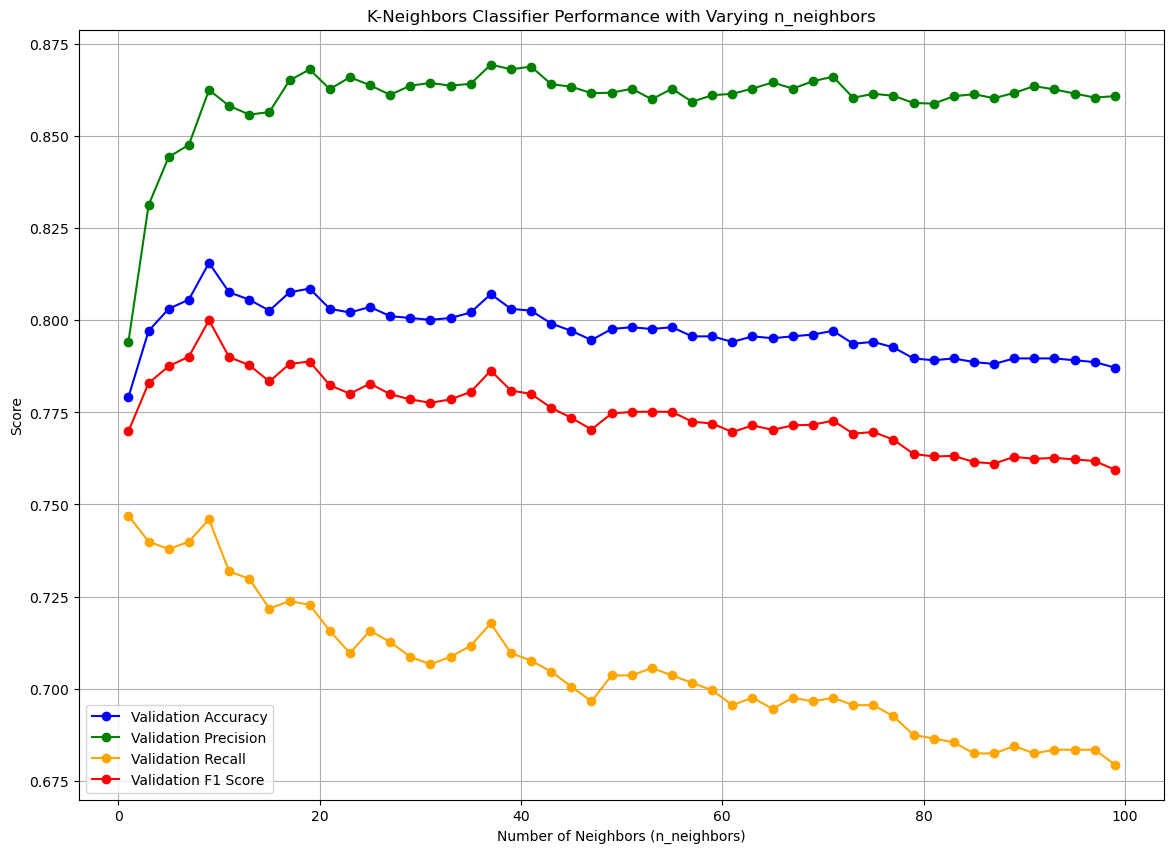

In [28]:
val_accs = [x[0] for x in accs]
train_accs = [x[1] for x in accs]
val_prec = [x[0] for x in prec]
train_prec = [x[1] for x in prec]
val_rec = [x[0] for x in rec]
train_rec = [x[1] for x in rec]
val_f1 = [x[0] for x in f1_scores]
train_f1 = [x[1] for x in f1_scores]

# Plot the results
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.plot(neighbors, val_accs, label='Validation Accuracy', marker='o', color='blue')

# Plot precision
plt.plot(neighbors, val_prec, label='Validation Precision', marker='o', color='green')

# Plot recall
plt.plot(neighbors, val_rec, label='Validation Recall', marker='o', color='orange')

# Plot F1 score
plt.plot(neighbors, val_f1, label='Validation F1 Score', marker='o', color='red')

# Add labels, title, and legend
plt.title('K-Neighbors Classifier Performance with Varying n_neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


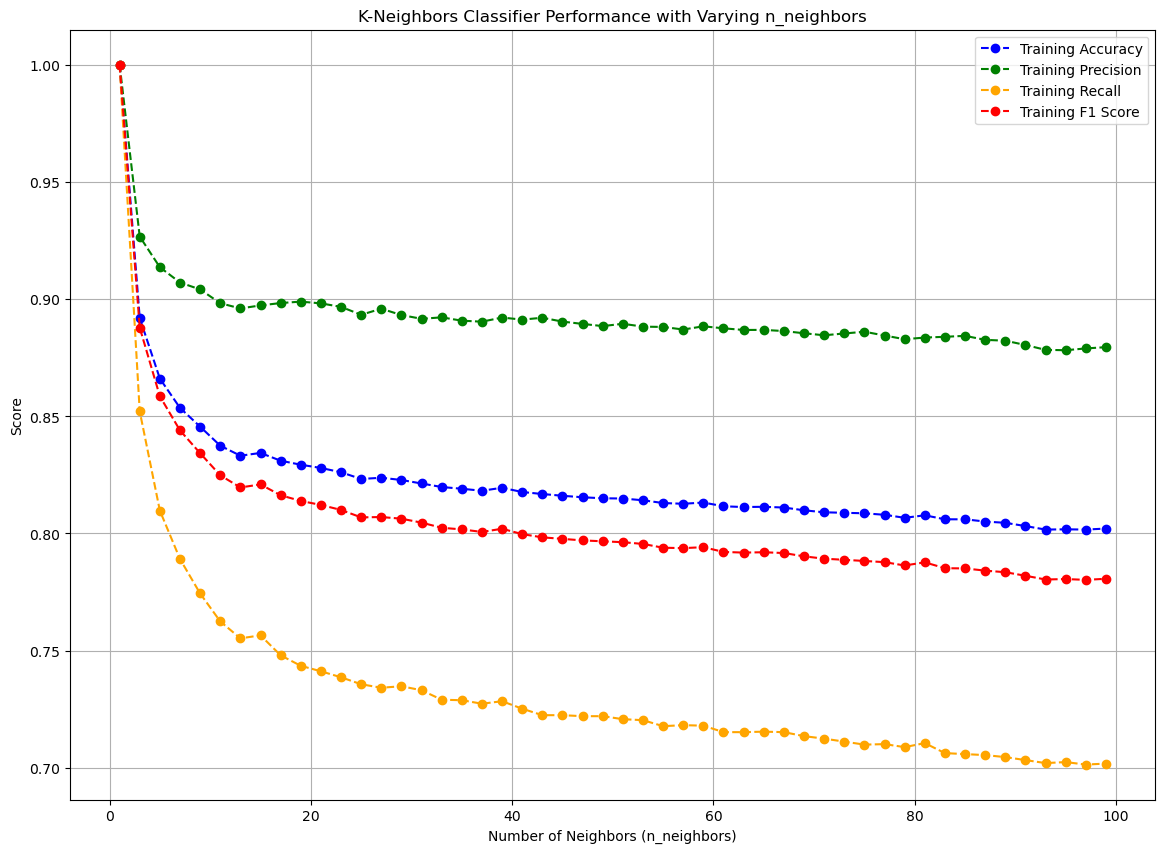

In [29]:
plt.figure(figsize=(14, 10))
plt.plot(neighbors, train_accs, label='Training Accuracy', marker='o', linestyle='--', color='blue')
plt.plot(neighbors, train_prec, label='Training Precision', marker='o', linestyle='--', color='green')
plt.plot(neighbors, train_rec, label='Training Recall', marker='o', linestyle='--', color='orange')
plt.plot(neighbors, train_f1, label='Training F1 Score', marker='o', linestyle='--', color='red')
plt.title('K-Neighbors Classifier Performance with Varying n_neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

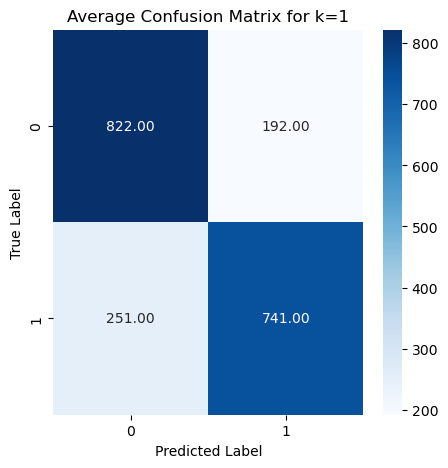

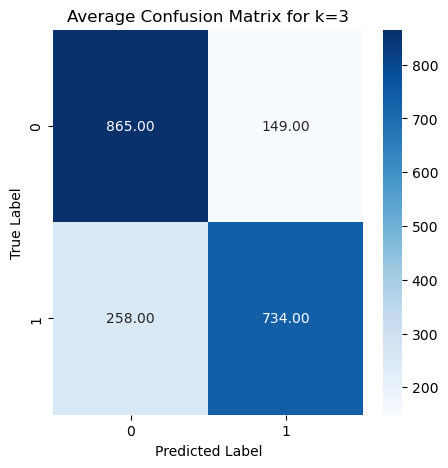

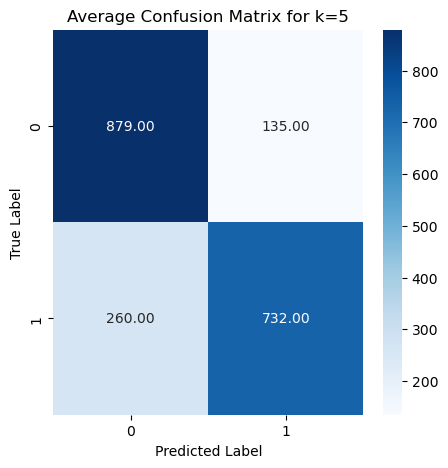

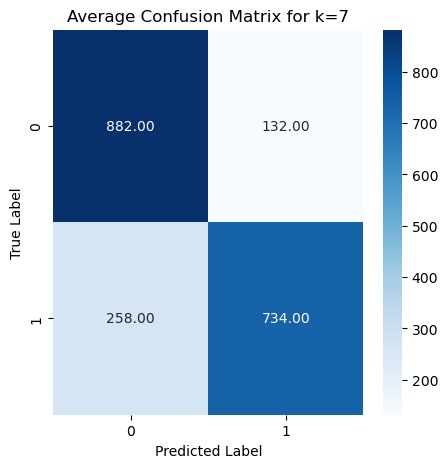

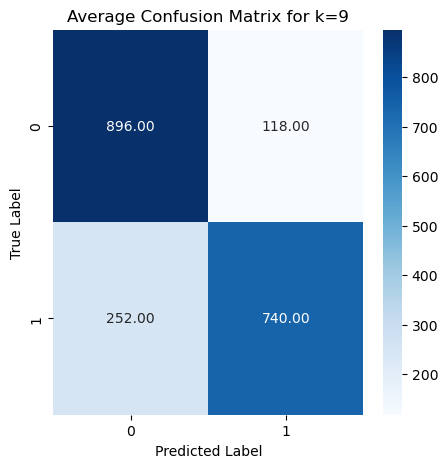

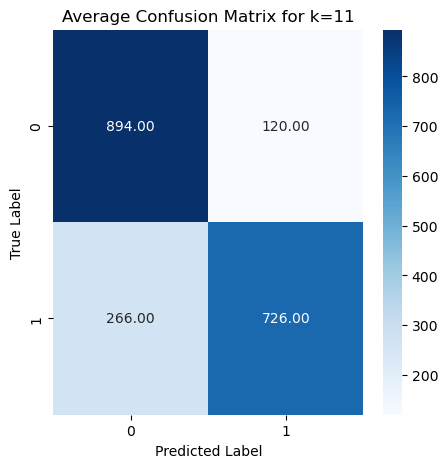

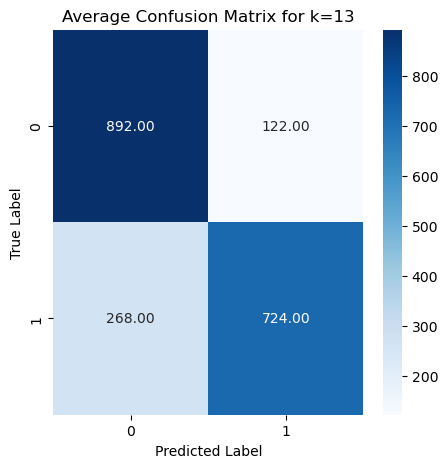

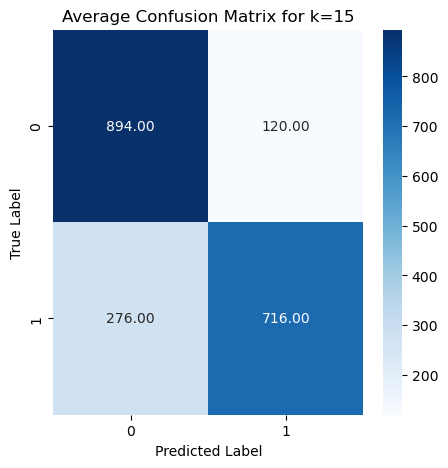

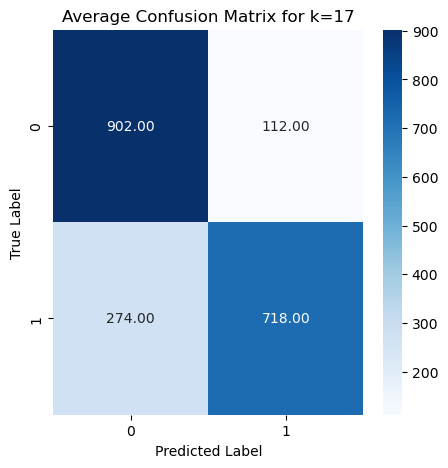

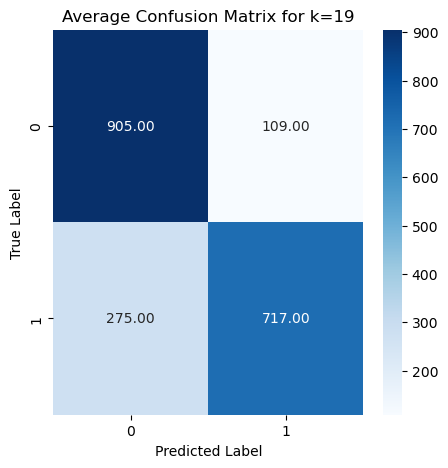

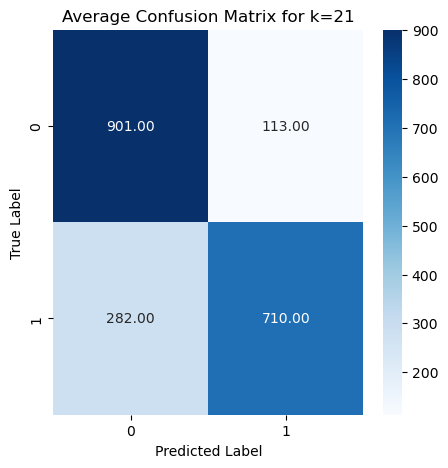

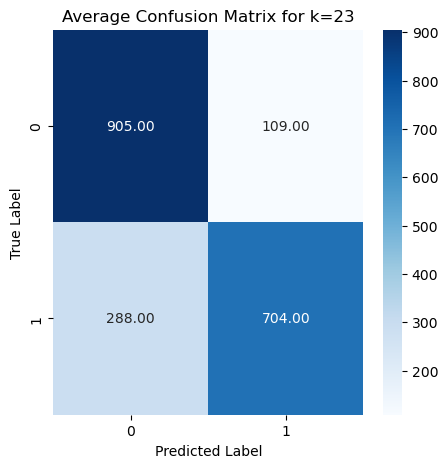

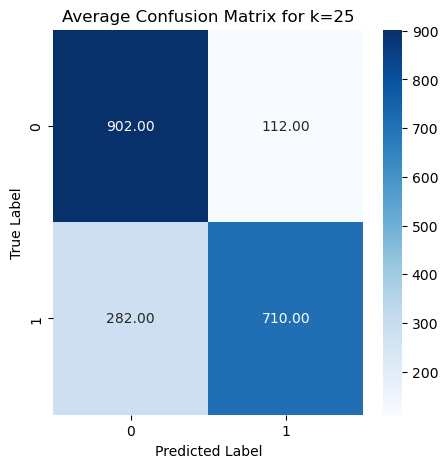

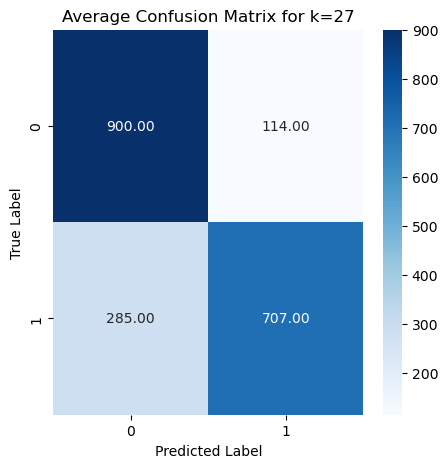

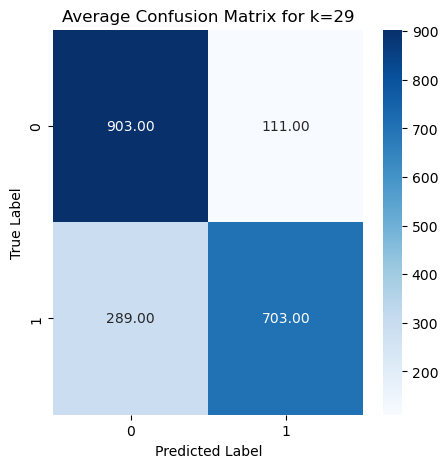

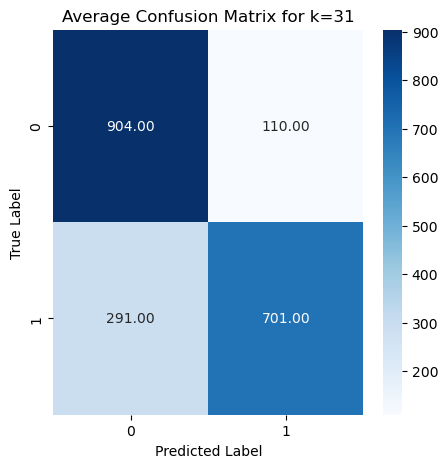

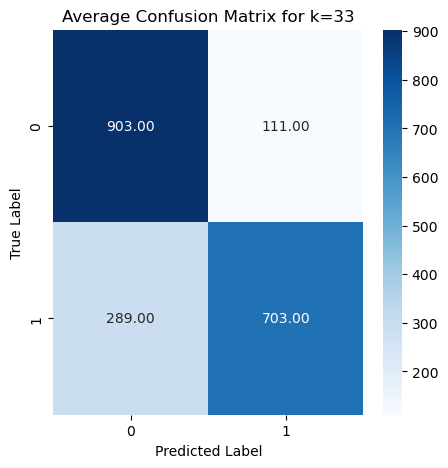

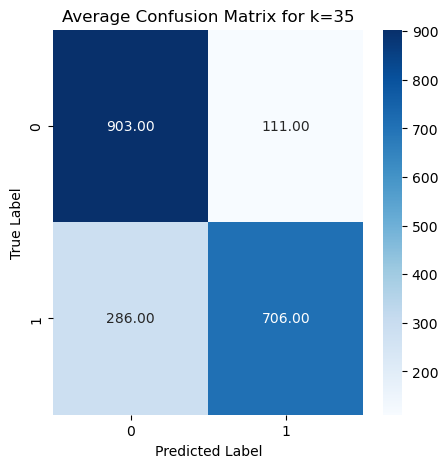

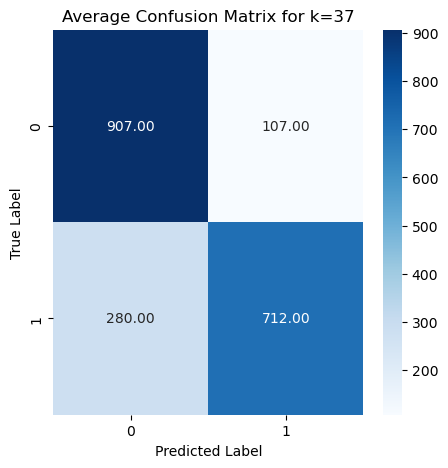

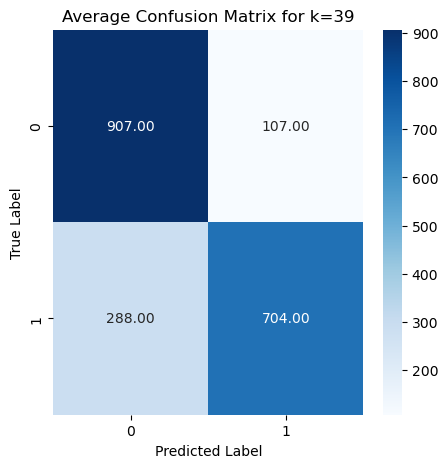

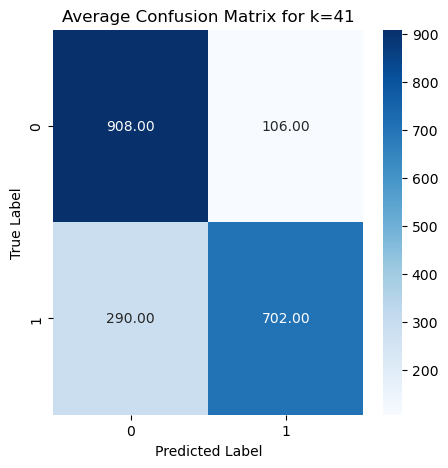

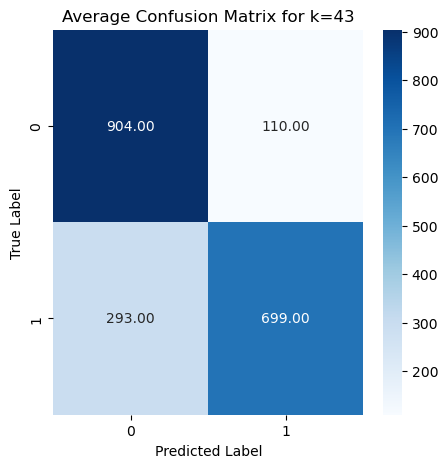

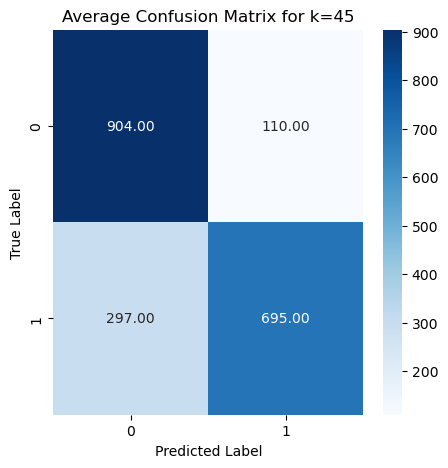

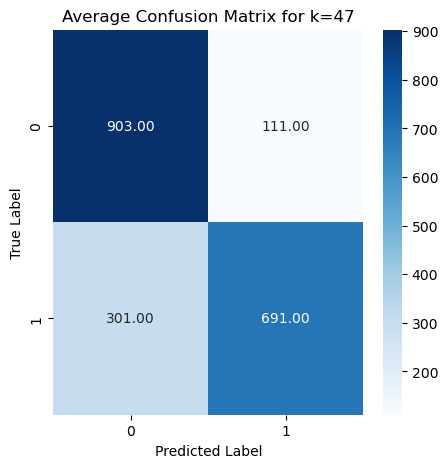

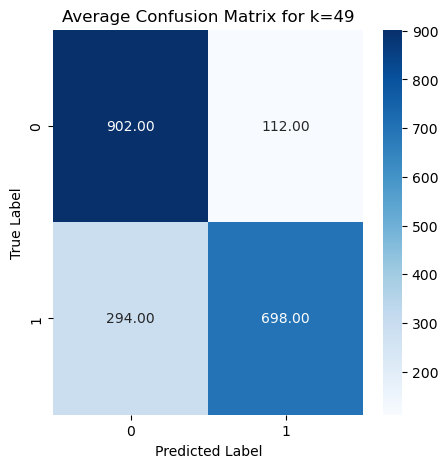

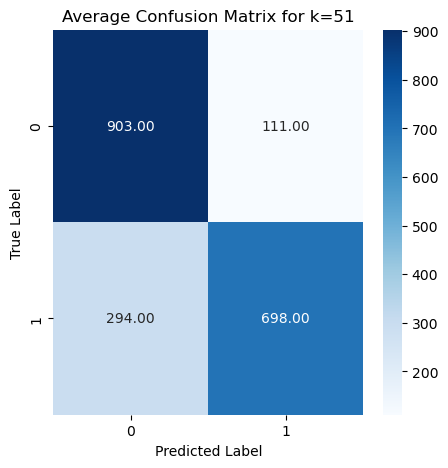

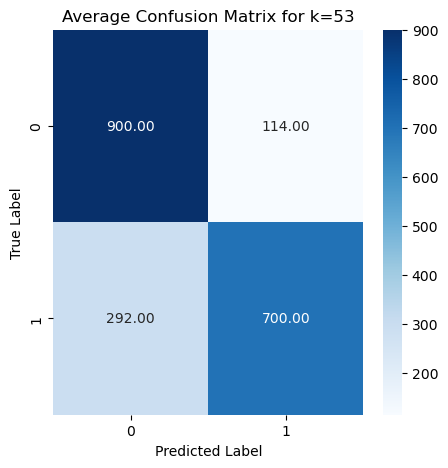

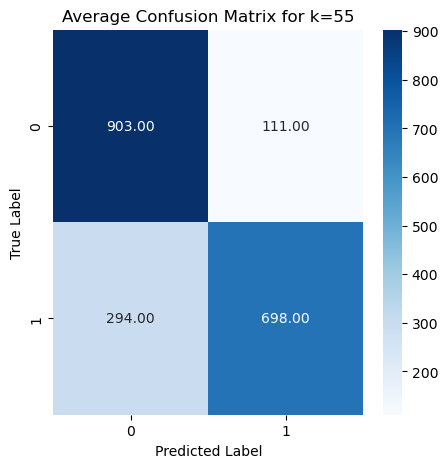

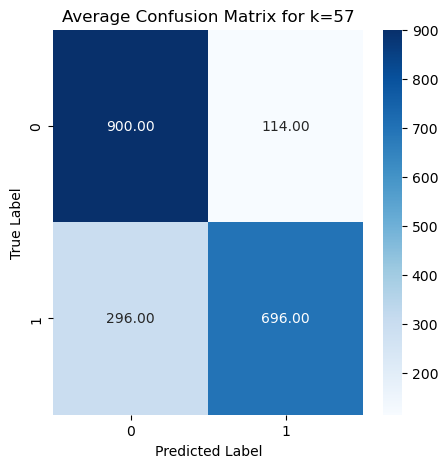

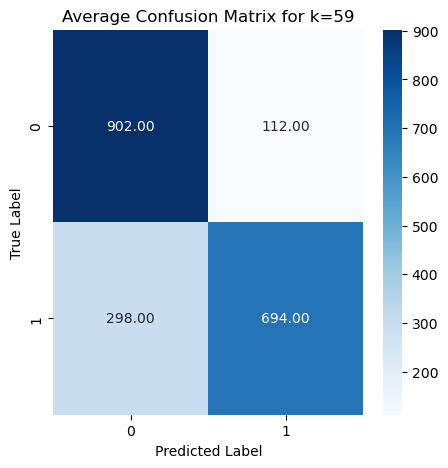

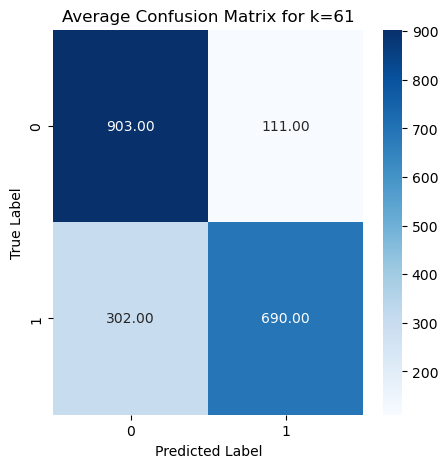

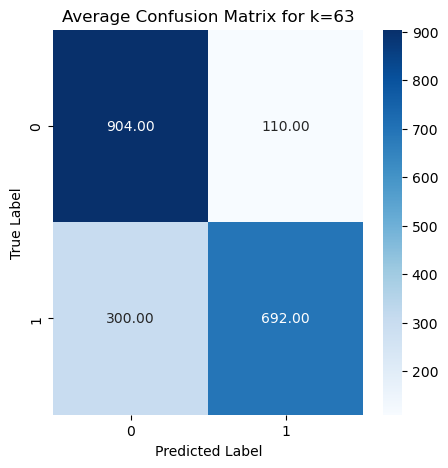

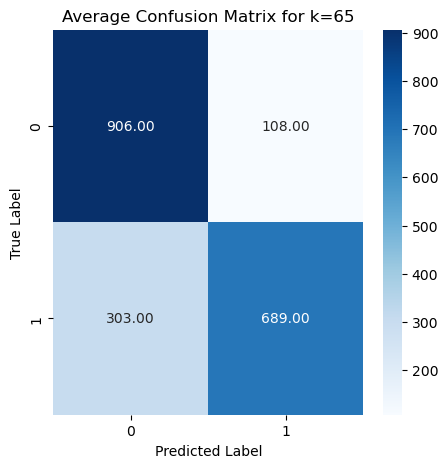

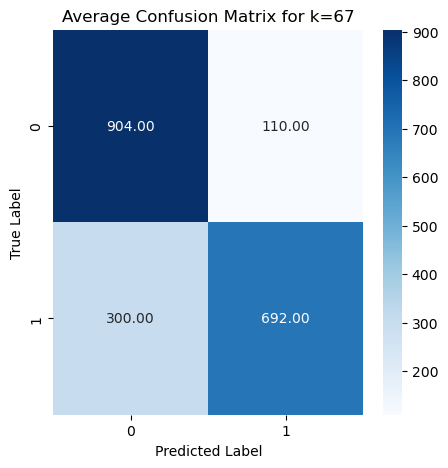

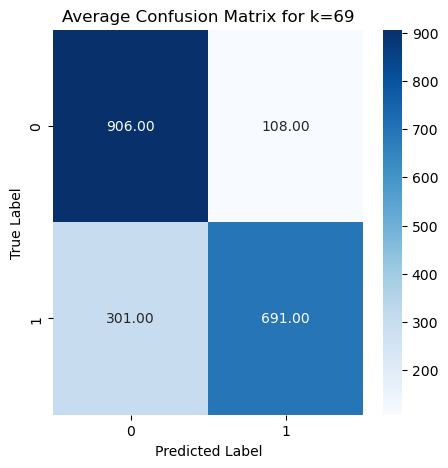

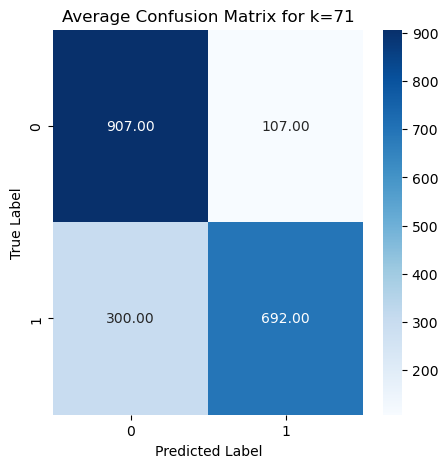

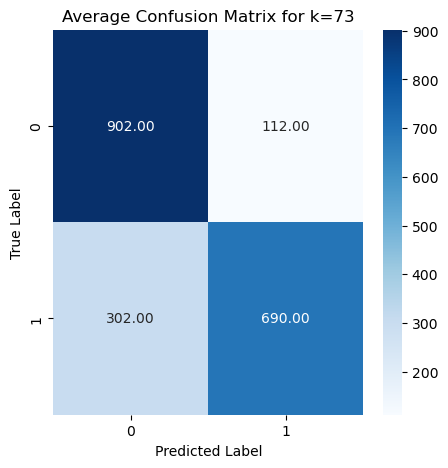

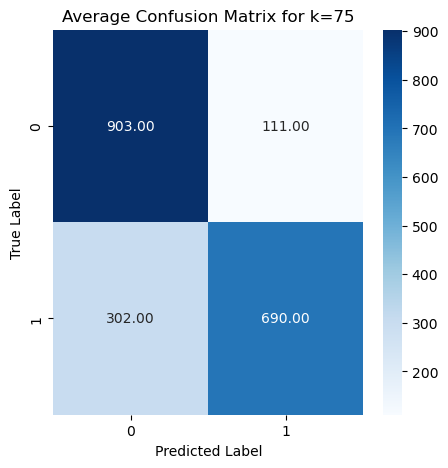

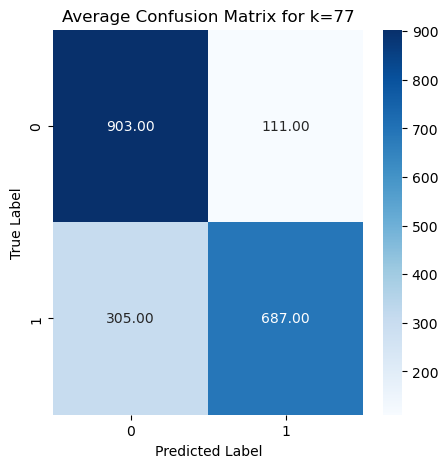

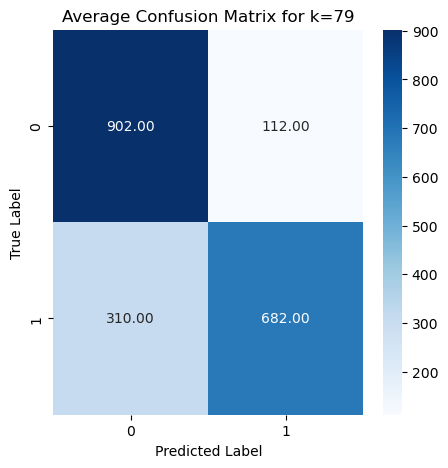

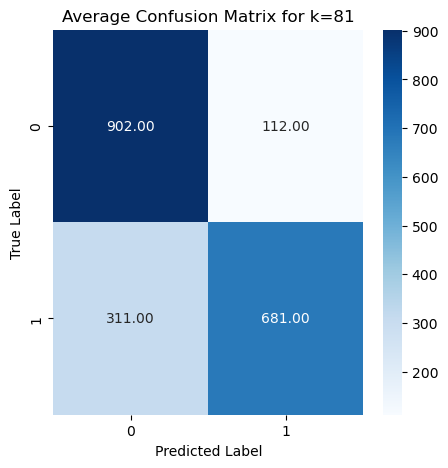

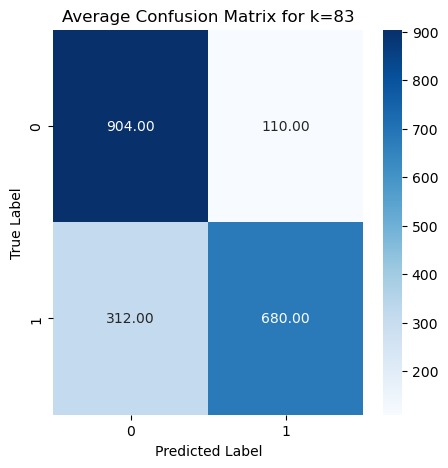

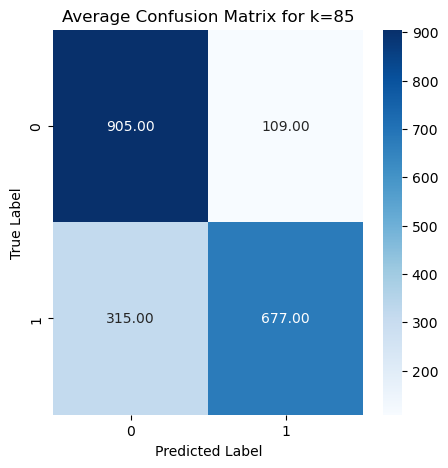

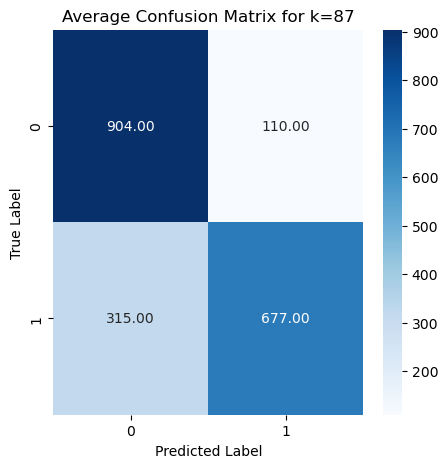

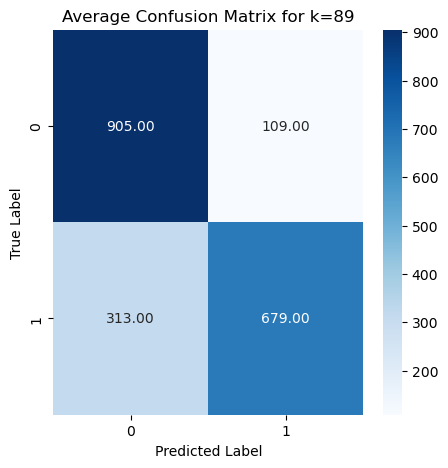

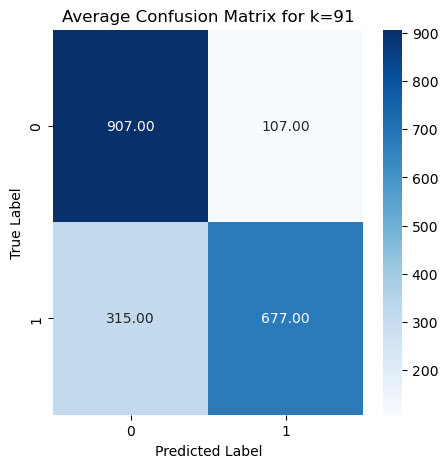

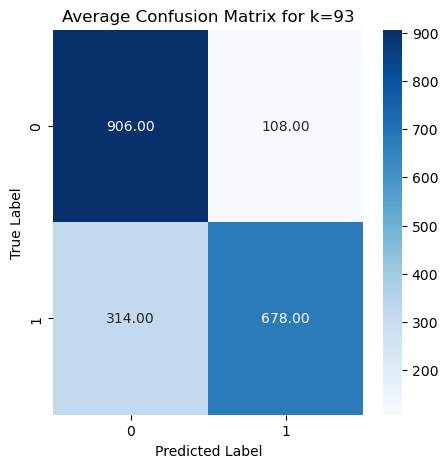

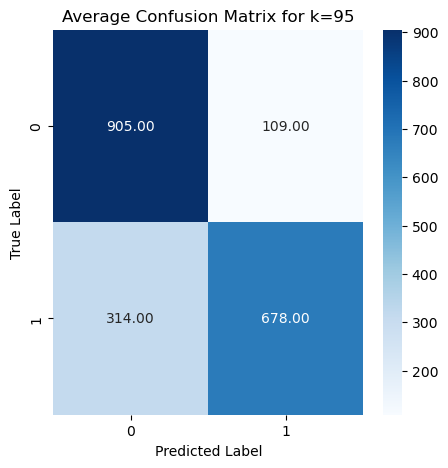

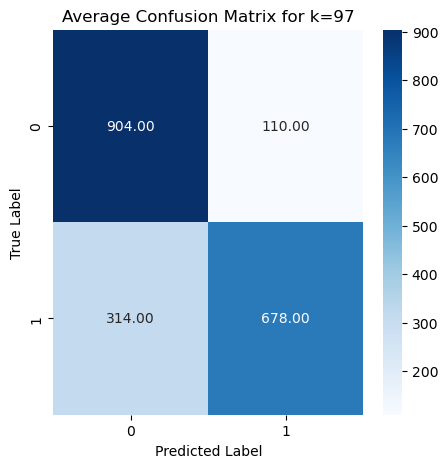

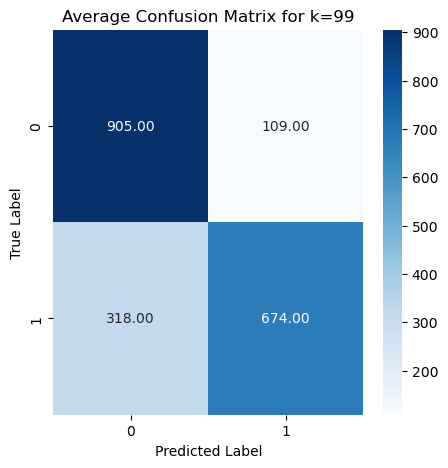

In [30]:
import seaborn as sns
for i, cm in enumerate(CMs):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Average Confusion Matrix for k={neighbors[i]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [31]:
best_k = neighbors[np.argmax(val_accs)]

print(f"best K value = {best_k}")
print(f"accuracy = {val_accs[np.argmax(val_accs)]}")
print(f"precision = {val_prec[np.argmax(val_accs)]}")
print(f"Recall = {val_rec[np.argmax(val_accs)]}")
print(f"F1 = {val_f1[np.argmax(val_accs)]}")

best K value = 9
accuracy = 0.8155533399800599
precision = 0.8624708624708625
Recall = 0.7459677419354839
F1 = 0.8


# Testing 

In [32]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9)

In [33]:
y_pred = model.predict(X_test)

In [34]:
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print(f"accuracy = {round(acc,2)}")
print(f"precision = {round(prec,2)}")
print(f"Recall = {round(rec,2)}")
print(f"F1 = {round(f1,2)}")


accuracy = 0.82
precision = 0.88
Recall = 0.74
F1 = 0.8


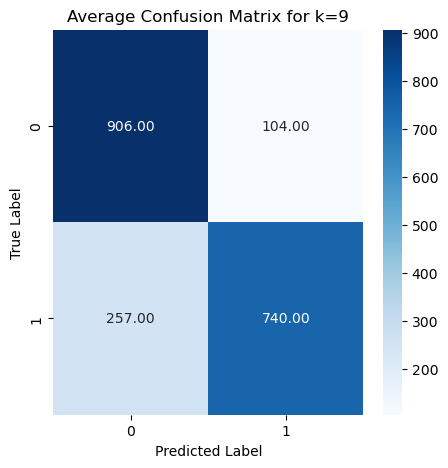

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title(f'Average Confusion Matrix for k={best_k}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()